## House pricing
Este proyecto se centra en la limpieza y análisis de un data set referente a casas de EUA y en la predicción del precio de venta de acuerdo a sus características

## Instalación de librerías

In [131]:
#!pip install lifelines
#!pip install plotly==4.14.3
#!pip install chart_studio

## IMPORTAR LIBRERÍAS

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
import plotly
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

## Conexión y limpieza

In [133]:
#Conexión a google colab desde drive, da un link para conectarse con el correo de gmail y copiar el código de autorización
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [134]:
#Importo mi BBDD "train" y con .head veo de que trata
#Con esta BBDD es con la que voy a entrenar a mi modelo para una futura predicción de precios
train = pd.read_csv('/content/drive/MyDrive/1. IRONHACK/BBDD/Copia de train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [135]:
#Con .shape sabré el número total de filas y columnas
#Las filas van a representar el total de casas que se tienen y las columnas las variables que se analizaron
#Hay un total de 1460 IDs (casas) y un total de 81 columnas (80 sin IDs)
train.shape

(1460, 81)

In [136]:
#Con .info conozco el conteo de no-nulos de las columnas y el tipo de dato que tiene cada una
#Veo que algunas de mis columnas tienen nulos
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [137]:
#Veo cuantos nulos totales hay en cada columna
train_nulls = train.isnull().sum()

#Veo que columnas en específico tienen valores nulos
columns_with_nulls = train_nulls[train_nulls > 0].sort_values()
#columns_with_nulls

#Hago una lista de mis columnas que tienen más del 20% de nulos
columns_with_nulls = list(train_nulls[train_nulls > 1460*0.2].index)
display('Las siguientes columnas ya no deben estar en el dataframe:')
display(columns_with_nulls)

#Borro esas columnas de mi dataframe train y guardo el nuevo dataframe en una variable que se llama clean_train
clean_train = train.drop(columns_with_nulls, axis=1)
clean_train.head()


'Las siguientes columnas ya no deben estar en el dataframe:'

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


In [138]:
#Confirmo que mi nuevo dataframe ya no tenga las 5 columnas que se eliminaron
#clean_train.info()

In [139]:
#de mis columnas restantes, veo cuales todavía tienen nulos
null_2 = clean_train.isnull().sum()

columns_with_nulls_2 = null_2[null_2 > 0].sort_values()
columns_with_nulls_2


Electrical        1
MasVnrType        8
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtFinType1     37
BsmtExposure     38
BsmtFinType2     38
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
LotFrontage     259
dtype: int64

In [145]:
# En las columnas que aun tienen nulls, voy a rellenar esos espacios con la moda de esa misma columna
for column in columns_with_nulls_2.index:
  if clean_train[column].dtype=='object':
    value = str(clean_train[column].mode()[0])
  else:
    value = float(clean_train[column].mode()[0])
  clean_train[column] = clean_train[column].fillna(value)

In [146]:
#Checo de nuevo mi dataframe clean_train para validar que ya no hay nulos
null_2 = clean_train.isnull().sum()

columns_with_nulls_2 = null_2[null_2 > 0].sort_values()
columns_with_nulls_2

Series([], dtype: int64)

## Análisis para ayudar al vendedor
¿Qué nos dice la información de entrada?

In [147]:
#Con .describe tenemos datos de todas nuestras variables numéricas de manera general
clean_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,68.267123,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1979.976027,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,22.356355,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.749688,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1962.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,63.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1984.500000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2003.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


# Datos interesantes:
- La media del tamaño del terreno es 10,517 pies cuadrados
- La calificación media es 6
- La media del año de construcción es 1971
- La media del año de remodelación es 1985
- La media del tamaño del sotano es 1,057 pies cuadrados
- La media de carros es casi 2
- La media del Precio de venta es $180,921

In [148]:
#Con .describe (include = "object") tenemos datos de todas nuestras variables categóricas de manera general
clean_train.describe(include = "object")

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
unique,5,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,6,3,5,5,3,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
freq,1151,1454,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,872,906,1282,647,686,1348,991,467,1294,1428,741,1365,1335,735,1360,951,686,1392,1407,1340,1267,1198


# Datos interesantes:
- La mayoría de casas esta en una zona residencial con poca gente (RL)
- La mayoría de casas tienen todos los servicios públicos
- El vecindario con más casas es NAmes
- La mayoría de casas tienen aire acondicionado
- la mayoría de casas tienen el Garage como parte de la casa

¿Qué variables numércias afectan más al precio de venta? 

In [149]:
#Matriz de correlación entre todas las variables numéricas, es una correlación de pearson, mide la correlación lineal
clean_train_corr = clean_train.corr()
#clean_train_corr

#Sabemos en orden de la mayor a la menor variable que afecta elprecio de venta, con .head(10) vemos las 10 más importantes
columns_correlated = clean_train_corr.sort_values('SalePrice', ascending=False)['SalePrice'].head(11)
columns_correlated

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

In [150]:
#Pasamos a una lista las columnas con la mayor correlación con el precio de venta
columns_list = columns_correlated.index.to_list()
columns_list

['SalePrice',
 'OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd']

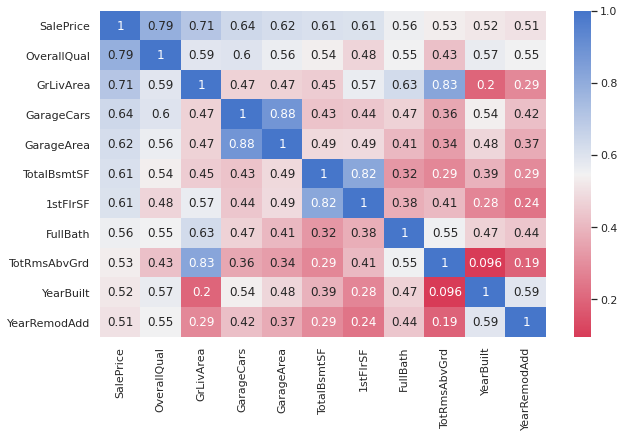

In [151]:
#matriz de correlación con colores
#asignar tamaño de grafica
sns.set(rc={'figure.figsize':(10,6)})
colores_corr_train = clean_train[columns_list].corr()
cmap = sns.diverging_palette(6,255,as_cmap=True)
sns.heatmap(colores_corr_train, cmap=cmap, annot=True)
#mas rojo, correlación negativa

## Gráficas con las variables que más correlación tienen con el precio

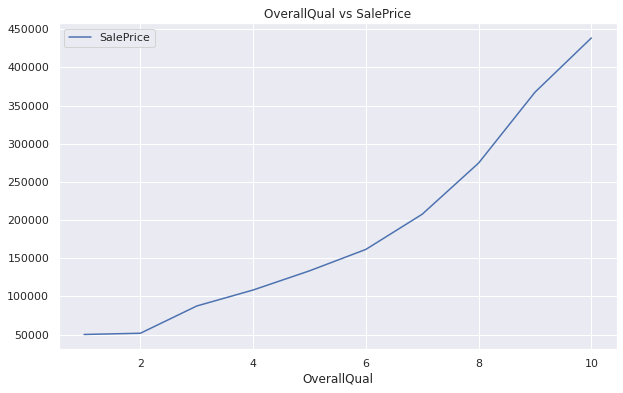

In [152]:
#Relación calidad general de la casa y precio de venta
clean_train[['OverallQual','SalePrice']].groupby('OverallQual').mean().plot(kind='line', title ='OverallQual vs SalePrice')
#Podemos ver correlación lineal positiva, esto significa que mientras más alta es la calificación general de la casa, es más cara

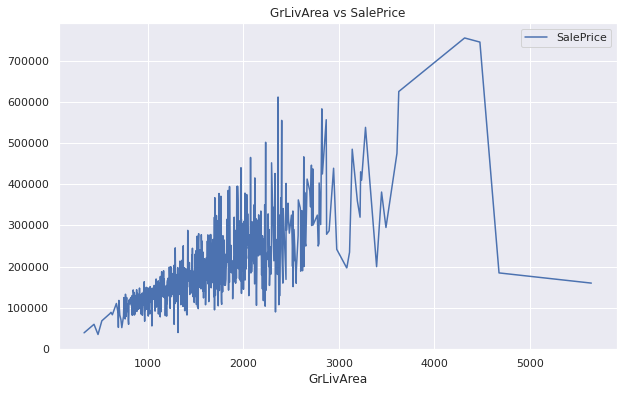

In [153]:
#Relación tamaño de la sala y precio de venta
clean_train[['GrLivArea','SalePrice']].groupby('GrLivArea').mean().plot(kind='line', title ='GrLivArea vs SalePrice')
#Podemos ver correlación lineal positiva, esto significa que mientras más alta es la sala de la casa, es más cara

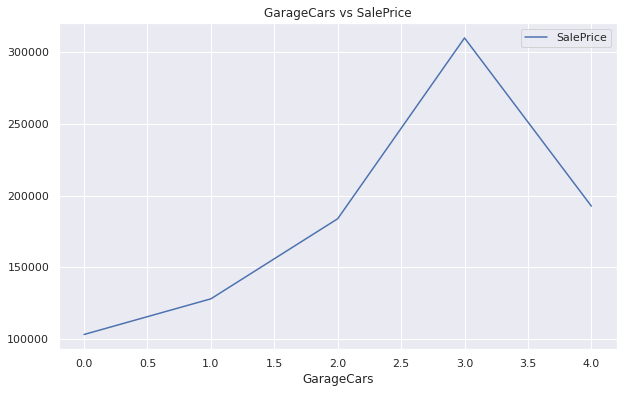

In [154]:
#Relación cantidad de carros en el garage y precio de venta
clean_train[['GarageCars','SalePrice']].groupby('GarageCars').mean().plot(kind='line', title ='GarageCars vs SalePrice')
#Podemos ver correlación lineal positiva, esto significa que mientras carros quepan, más cara es, pero después de 3 carros el precio baja
#esto puede significar que las personas aprecian tener espacio para 3 carros pero para más no tanto, ¿preferirían mayor espacio en la casa?

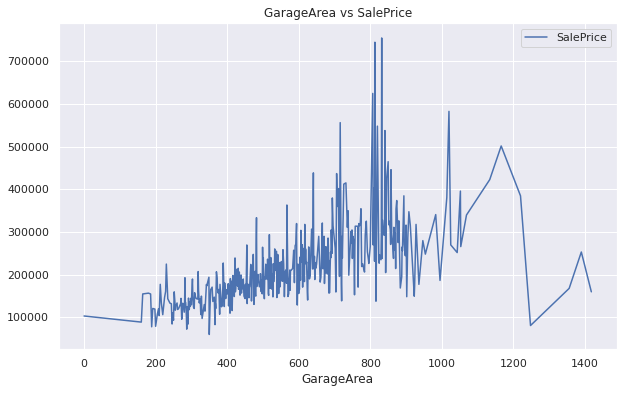

In [155]:
#Relación pies cuadrados de garage y precio de venta
clean_train[['GarageArea','SalePrice']].groupby('GarageArea').mean().plot(kind='line', title ='GarageArea vs SalePrice')
#Los garages con 800 pies cuardados son los más caros, después de eso el precio baja

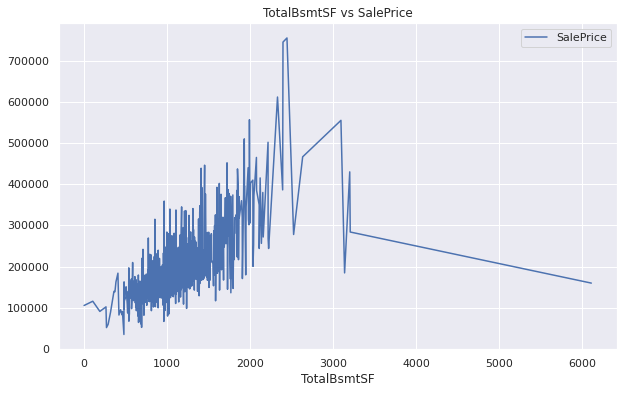

In [156]:
#Relación tamaño sótano y precio de venta
clean_train[['TotalBsmtSF','SalePrice']].groupby('TotalBsmtSF').mean().plot(kind='line', title ='TotalBsmtSF vs SalePrice')
#Las casas con mayor % de venta estan entre los 1000 y los 2000 pies cuadrados de sótano

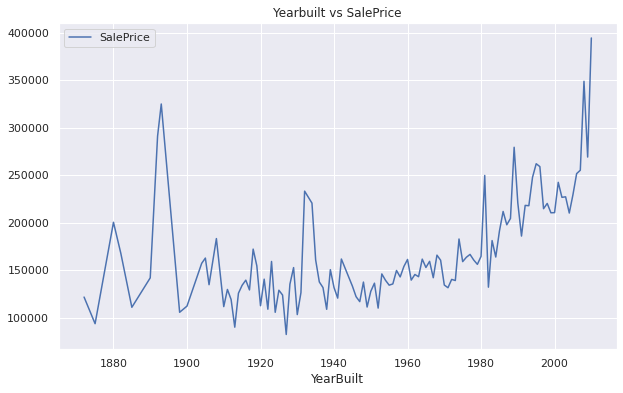

In [157]:
#Relación año de construcción y precio de venta
clean_train[['YearBuilt','SalePrice']].groupby('YearBuilt').mean().plot(kind='line', title ='Yearbuilt vs SalePrice')
#Las casas empezaron a subir de precio en 1960, las casas más modernas son más caras, exceptuando las casas que rondan los años de 1990

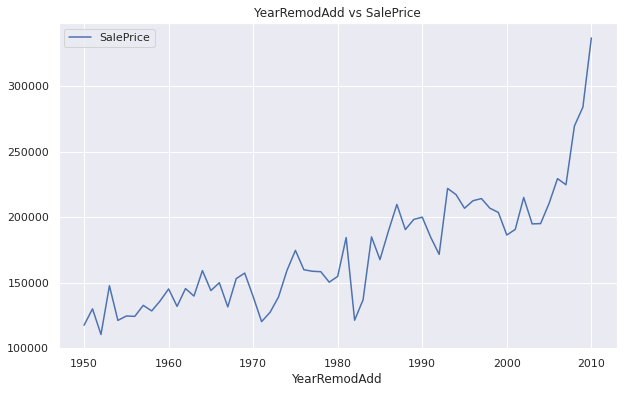

In [158]:
#Relación año de de remodelación y precio de venta
clean_train[['YearRemodAdd','SalePrice']].groupby('YearRemodAdd').mean().plot(kind='line', title ='YearRemodAdd vs SalePrice')
#Las casas mientras más cercano es su año de remodelación, más caras son

Si un vendedor quisiera empezar a vender casas, ¿Cuáles son los 5 vecindarios que tienen en promedio, los mayores precios de venta?

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

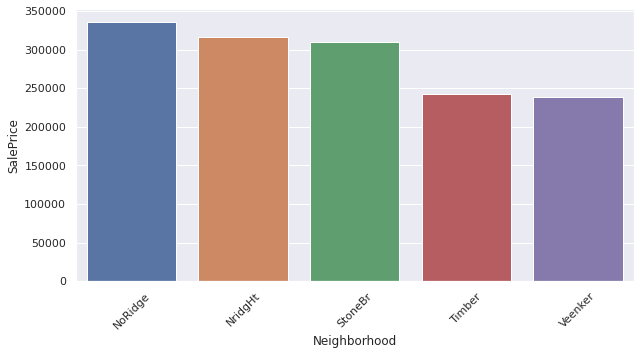

In [159]:
sell_neighborhood = clean_train.groupby('Neighborhood').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending=False).reset_index()
top_5_neighborhoods = sell_neighborhood.head(5)
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.barplot(x="Neighborhood", y="SalePrice", data=top_5_neighborhoods)
plt.xticks(rotation=45)
#Si un vendedor quisiera empezar, los vecindarios que mayor promedio en precio de venta han sido los siguientes 5:

# crosstab para saber el vecindario que mejor queda de acuerdo a las características

In [160]:
#Top 5 vecindarios que tienen la mejor "OveralQual"
crosstab = pd.crosstab(clean_train['Neighborhood'], clean_train['OverallQual']).sort_values(10,ascending=False)
crosstab.head(5)

OverallQual,1,2,3,4,5,6,7,8,9,10
Neighborhood,,,,,,,,,,
NridgHt,0,0,0,0,0,2,16,27,24,8
NoRidge,0,0,0,0,0,0,12,24,1,4
Edwards,1,0,5,25,38,23,5,0,1,2
OldTown,0,0,6,17,47,22,16,3,0,2
StoneBr,0,0,0,0,0,0,3,16,5,1


# Pruebas de hipótesis para variables categóricas

## Vamos a comprobar si las siguientes variables no numéricas influyen en el precio de venta:
El vecindario se cruzó con todas las variables

- Utilities = AllPub (incluidos todos los servicios públicos)
-  Condition1 = Artery (que la casa se encuentra adyacente a una avenida principal)
- BsmtCond = Condición general del Sótano
- GarageQual = Calidad general del Garage

In [161]:
model_amb = ols("SalePrice ~ C(clean_train['Neighborhood'])+ C(clean_train['Utilities'] == 'AllPub') + (C(clean_train['Neighborhood']) * C(clean_train['Utilities'] == 'AllPub'))", data=clean_train).fit()
sm.stats.anova_lm(model_amb, typ=2)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1752: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 24, but rank is 1



,sum_sq,df,F,PR(>F)
C(clean_train['Neighborhood']),3.739425e+12,24.0,53.541506,4.198824e-13
C(clean_train['Utilities'] == 'AllPub'),4.733143e+11,1.0,162.647181,2.300713e-35
C(clean_train['Neighborhood']):C(clean_train['Utilities'] == 'AllPub'),4.879307e+12,24.0,69.862457,5.877265e-221
Residual,4.173037e+12,1434.0,NaN,NaN


este anova nos da de conclusión que tanto el vecindario por si solo, como el tener todos los servicios públicos como la relación de ambos, influyen en el precio de venta (Sabemos esto porque todos los valores de PR(>F) son menores a 0.05)

In [162]:
model_amb = ols("SalePrice ~ C(clean_train['Neighborhood'])+ C(clean_train['Condition1'] == 'Artery') + (C(clean_train['Neighborhood']) * C(clean_train['Condition1'] == 'Artery'))", data=clean_train).fit()
sm.stats.anova_lm(model_amb, typ=2)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1752: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 24, but rank is 6

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1752: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1768: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1752: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 24, but rank is 6



,sum_sq,df,F,PR(>F)
C(clean_train['Neighborhood']),4.527840e+12,24.0,64.621236,3.799531e-71
C(clean_train['Condition1'] == 'Artery'),NaN,1.0,NaN,NaN
C(clean_train['Neighborhood']):C(clean_train['Condition1'] == 'Artery'),4.950860e+10,24.0,0.706586,6.443473e-01
Residual,4.171928e+12,1429.0,NaN,NaN


Este ANOVA nos da de conclusión que la interacción entre el Vecindario y ubicarse adyacentemente a una avenida principal, NO INFLUYE en el precio de venta

In [163]:
model_amb = ols("SalePrice ~ C(clean_train['Neighborhood'])+ C(clean_train['BsmtCond']) + (C(clean_train['Neighborhood']) * C(clean_train['BsmtCond']))", data=clean_train).fit()
sm.stats.anova_lm(model_amb, typ=2)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1752: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 24, but rank is 4

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1752: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 72, but rank is 45



,sum_sq,df,F,PR(>F)
C(clean_train['Neighborhood']),2.766693e+12,24.0,39.759425,1.407968e-31
C(clean_train['BsmtCond']),5.554787e+11,3.0,63.861105,1.059535e-38
C(clean_train['Neighborhood']):C(clean_train['BsmtCond']),5.351526e+12,72.0,25.635123,6.212019e-150
Residual,4.062074e+12,1401.0,NaN,NaN


Este ANOVA nos da de conclusión que la condición general del sótano influye en el precio de venta
Además, la interacción entre el vecindario y la condición general del sótano también influyen en el precio de venta

In [164]:
model_amb = ols("SalePrice ~ C(clean_train['Neighborhood'])+ C(clean_train['MSZoning']) + (C(clean_train['Neighborhood']) * C(clean_train['MSZoning']))", data=clean_train).fit()
sm.stats.anova_lm(model_amb, typ=2)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1752: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 24, but rank is 12

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1752: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 4, but rank is 0

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1768: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1752: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 96, but rank is 38



,sum_sq,df,F,PR(>F)
C(clean_train['Neighborhood']),-3.602029e+02,24.0,-5.307578e-09,1.000000e+00
C(clean_train['MSZoning']),NaN,4.0,NaN,NaN
C(clean_train['Neighborhood']):C(clean_train['MSZoning']),1.245012e+13,96.0,4.586301e+01,1.403407e-216
Residual,4.009736e+12,1418.0,NaN,NaN


Este ANOVA nos da la conclusión de que la interacción entre el vecindario y la zona de la casa si influye en el precio de venta

## ANÁLISIS DE VARIABLES NUMÉRCIAS Y MODELO DE PREDICCIÓN

## Vamos a comprobar si las siguientes variables númericas afectan al precio de venta:
- GrLivArea: Above grade (ground) living area square feet
- GarageCars: Size of garage in car capacity
- TotalBsmtSF: Total square feet of basement area
- 1stFlrSF: First Floor square feet
- FullBath: total full baths
- TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
- YearBuilt: Original construction date
- YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
- Fireplaces: total of fireplaces
- 2ndFlrSF: Second floor square feet
- Halfbath: total of halfbaths
- LotArea: Lot size in square feet
- PoolArea: total area of the pool in square feet
- KitchenAbvGr: Kitchens above grade

In [165]:
X = sm.add_constant(clean_train[['GrLivArea','GarageCars','TotalBsmtSF','1stFlrSF','FullBath','TotRmsAbvGrd','YearBuilt','YearRemodAdd','Fireplaces','2ndFlrSF','HalfBath','LotArea','PoolArea','KitchenAbvGr']]) # adding a constant
Y = clean_train['SalePrice']

In [166]:
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     313.2
Date:                Wed, 27 Jan 2021   Prob (F-statistic):               0.00
Time:                        06:28:11   Log-Likelihood:                -17526.
No. Observations:                1460   AIC:                         3.508e+04
Df Residuals:                    1445   BIC:                         3.516e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.841e+06   1.36e+05    -13.566   

Este resumen nos indica lo siguiente:
* la R^2 normal como ajustada esta en 0.75, lo que indica que es un buen modelo
* Todas las variables cuyo valor es 0 en P>|t|, influyen en el precio de venta
* Las variables que cuyo valor NO es 0, tienen ese % de creer que influyen en el modelo "por suerte". Por ejemplo, tengo un 44.2% de confianza en que la variable HalfBath influyó por suerte (o lo que es lo mismo, tengo un 55.8% de confianza en que HalfBath NO influye en el precio de venta) 

In [167]:
#Comparación de lo que me predijo el modelo VS los precios actuales
df_compare = pd.DataFrame({'Actual': Y, 'Predicted':predictions})
df_compare

,Actual,Predicted
0,208500,207753.578783
1,181500,178926.823610
2,223500,221685.800671
3,140000,182493.571121
4,250000,278703.931532
...,...,...
1455,175000,212886.162971
1456,210000,263224.415803
1457,266500,240824.682133
1458,142125,131073.286714


In [168]:
#El error que obtengo con este modelo, es de $24,753 
#Dado que tengo precios que llegan por arriba de los $10,000,000, los $24,753 no representan un gran % (es un buen modelo)
metrics.mean_absolute_error(Y,predictions)

24753.689758521865

# PREDICCIONES CON DATA SET "TEST"

In [169]:
#importo el dataset de test, es el mismo que train pero sin la columna de precio de venta
test = pd.read_csv('/content/drive/MyDrive/1. IRONHACK/BBDD/Copia de test.csv')
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [170]:
#Hago una copia de test
test_copy = test.copy()

In [171]:
#Vamos a entrenar al modelo e incluirle la columna de Sales_predictions
X_test = sm.add_constant(test_copy[['GrLivArea','GarageCars','TotalBsmtSF','1stFlrSF','FullBath','TotRmsAbvGrd','YearBuilt','YearRemodAdd','Fireplaces','2ndFlrSF','HalfBath','LotArea','PoolArea','KitchenAbvGr']]) # adding a constant

predictions_test = model.predict(X_test) 
predictions_test

test_copy['sales_predictions'] = predictions_test
test_copy

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,sales_predictions
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,...,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,99450.952357
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,...,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,140271.076784
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,...,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,209239.013884
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,...,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,208432.854649
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,...,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,181930.741902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,...,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,83964.370094
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,...,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,103994.852262
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,...,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abno

# Predecir el precio de la casa armada por un usuario (comprador)
Vamos a darle al usuario la posibilidad de definir las variables que nuestro modelo usa, para calcular el precio que tendría su casa soñada

In [172]:
#Definimos todas las variables que son de nuestro interes para el entrenamiento del modelo
LotArea = int(input('Escribe cuantos pies cuadrados quieres que tenga tu propiedad:'))
if LotArea > test.LotArea.max():
  LotArea = test.LotArea.max()

Escribe cuantos pies cuadrados quieres que tenga tu propiedad:1200


In [173]:
GrLivArea = int(input('Escribe cuantos pies cuadrados quieres que tenga sala en tu casa:'))
if GrLivArea > test.GrLivArea.max():
  GrLivArea = test.GrLivArea.max()

Escribe cuantos pies cuadrados quieres que tenga sala en tu casa:500


In [174]:
GarageCars = int(input('Escribe cuantos carros es lo máximo que quepan en tu Garage:'))
if GarageCars > test.GarageCars.max():
  GarageCars = test.GarageCars.max()

Escribe cuantos carros es lo máximo que quepan en tu Garage:3


In [175]:
TotalBsmtSF = int(input('Escribe cuantos pies cuadrados quieres que tenga tu sótano:'))
if TotalBsmtSF > test.TotalBsmtSF.max():
  TotalBsmtSF = test.TotalBsmtSF.max()

Escribe cuantos pies cuadrados quieres que tenga tu sótano:500


In [176]:
_1stFlrSF = int(input('Escribe cuantos pies cuadrados quieres que tenga tu primer piso:'))
if _1stFlrSF > test['1stFlrSF'].max():
  _1stFlrSF = test['1stFlrSF'].max()

Escribe cuantos pies cuadrados quieres que tenga tu primer piso:500


In [177]:
FullBath = int(input('Escribe cuantos baños completos quieres:'))
if FullBath > test['FullBath'].max():
  FullBath = test['FullBath'].max()

Escribe cuantos baños completos quieres:3


In [178]:
TotRmsAbvGrd = int(input('Escribe cuantos cuartos por arriba del sótano quieres:'))
if TotRmsAbvGrd > test['TotRmsAbvGrd'].max():
  TotRmsAbvGrd = test['TotRmsAbvGrd'].max()

Escribe cuantos cuartos por arriba del sótano quieres:3


In [179]:
YearBuilt = int(input('Escribe de que año te gustaría que fuera tu casa:'))
if YearBuilt > test['YearBuilt'].max():
  YearBuilt = test['YearBuilt'].max()
elif YearBuilt < test['YearBuilt'].min():
  YearBuilt = test['YearBuilt'].min()

Escribe de que año te gustaría que fuera tu casa:1950


In [180]:
YearRemodAdd = int(input('Escribe en que año te gustaría que se haya remodelado por última vez:'))
if YearRemodAdd > test['YearRemodAdd'].max():
  YearRemodAdd = test['YearRemodAdd'].max()
elif YearRemodAdd < test['YearRemodAdd'].min():
  YearRemodAdd = test['YearRemodAdd'].min()

Escribe en que año te gustaría que se haya remodelado por última vez:2000


In [181]:
Fireplaces = int(input('Escribe cuantas chimeneas quieres:'))
if Fireplaces > test['Fireplaces'].max():
  Fireplaces = test['Fireplaces'].max()

Escribe cuantas chimeneas quieres:1


In [182]:
_2ndFlrSF = int(input('Escribe cuantos pies cuadrados quieres que tenga tu segundo piso:'))
if _2ndFlrSF > test['2ndFlrSF'].max():
  _2ndFlrSF = test['2ndFlrSF'].max()

Escribe cuantos pies cuadrados quieres que tenga tu segundo piso:600


In [183]:
HalfBath = int(input('Escribe cuantos medios baños quieres:'))
if HalfBath > test['HalfBath'].max():
  HalfBath  = test['HalfBath'].max()

Escribe cuantos medios baños quieres:3


In [184]:
PoolArea = int(input('Escribe cuantos pies cuadrados quieres que tenga la zona de alberca:'))
if PoolArea > test.PoolArea.max():
  PoolArea = test.PoolArea.max()

Escribe cuantos pies cuadrados quieres que tenga la zona de alberca:400


In [185]:
KitchenAbvGr = int(input('Escribe cuantas cocinas quieres:'))
if KitchenAbvGr > test['KitchenAbvGr'].max():
  KitchenAbvGr  = test['KitchenAbvGr'].max()

Escribe cuantas cocinas quieres:1


In [186]:
#Guardamos todas las variables en un diccionario
diccionario = {'LotArea':[LotArea],'GrLivArea': [GrLivArea], 'GarageCars': [GarageCars],'TotalBsmtSF': [TotalBsmtSF], '1stFlrSF': [_1stFlrSF],'FullBath':[FullBath] ,'TotRmsAbvGrd':[TotRmsAbvGrd] ,'YearBuilt':[YearBuilt] ,'YearRemodAdd':[YearRemodAdd], 'Fireplaces':[Fireplaces], '2ndFlrSF':[_2ndFlrSF], 'HalfBath':[HalfBath],'PoolArea':[PoolArea], 'KitchenAbvGr':[KitchenAbvGr]}
diccionario

{'1stFlrSF': [500],
 '2ndFlrSF': [600],
 'Fireplaces': [1],
 'FullBath': [3],
 'GarageCars': [3],
 'GrLivArea': [500],
 'HalfBath': [2],
 'KitchenAbvGr': [1],
 'LotArea': [1200],
 'PoolArea': [400],
 'TotRmsAbvGrd': [3],
 'TotalBsmtSF': [500],
 'YearBuilt': [1950],
 'YearRemodAdd': [2000]}

In [187]:
#Ese diccionario lo volvemos un DataFrame
user_df = pd.DataFrame(diccionario)
user_df

,LotArea,GrLivArea,GarageCars,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,Fireplaces,2ndFlrSF,HalfBath,PoolArea,KitchenAbvGr
0,1200,500,3,500,500,3,3,1950,2000,1,600,2,400,1


In [188]:
#creamos un DataFrame que contenga la nueva información de nuestro usuario y la unimos (concat) a nuestro test original
test_2 = pd.concat([test, user_df], axis=0)
test_2

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461.0,20.0,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5.0,6.0,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0.0,896,0.0,0.0,1,0,2.0,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140.0,0.0,0.0,0.0,120.0,0,NaN,MnPrv,NaN,0.0,6.0,2010.0,WD,Normal
1,1462.0,20.0,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6.0,6.0,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0.0,1329,0.0,0.0,1,1,3.0,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393.0,36.0,0.0,0.0,0.0,0,NaN,NaN,Gar2,12500.0,6.0,2010.0,WD,Normal
2,1463.0,60.0,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5.0,5.0,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0.0,1629,0.0,0.0,2,1,3.0,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212.0,34.0,0.0,0.0,0.0,0,NaN,MnPrv,NaN,0.0,3.0,2010.0,WD,Normal
3,1464.0,60.0,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6.0,6.0,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0.0,1604,0.0,0.0,2,1,3.0,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360.0,36.0,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0,6.0,2010.0,WD,Normal
4,1465.0,120.0,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8.0,5.0,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0.0,1280,0.0,0.0,2,0,2.0,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0.0,82.0,0.0,0.0,144.0,0,NaN,NaN,NaN,0.0,1.0,2010.0,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2916.0,160.0,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4.0,5.0,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0.0,1092,0.0,0.0,1,1,3.0,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0.0,24.0,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0,4.0,2006.0,WD,Abnorml
1456,2917.0,20.0,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5.0,7.0,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0.0,1224,1.0,0.0,1,0,4.0,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474.0,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0,9.0,2006.0,WD,Abnorml
1457,2918.0,85.0,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5.0,5.0,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0.0,970,0.0,1.0,1,0,3.0,1

In [189]:
#Vamos a entrenar al modelo e incluirle la columna de Sales_predictions
X_test_2 = sm.add_constant(test_2[['LotArea','GrLivArea','GarageCars','TotalBsmtSF','1stFlrSF','FullBath','TotRmsAbvGrd','YearBuilt','YearRemodAdd','Fireplaces','2ndFlrSF','HalfBath','PoolArea','KitchenAbvGr']]) # adding a constant

predictions_test_2 = model.predict(X_test_2) 

test_2['sales_predictions'] = predictions_test_2
test_2

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,sales_predictions
0,1461.0,20.0,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5.0,6.0,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,...,Y,SBrkr,896,0,0.0,896,0.0,0.0,1,0,2.0,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140.0,0.0,0.0,0.0,120.0,0,NaN,MnPrv,NaN,0.0,6.0,2010.0,WD,Normal,3.551700e+07
1,1462.0,20.0,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6.0,6.0,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,...,Y,SBrkr,1329,0,0.0,1329,0.0,0.0,1,1,3.0,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393.0,36.0,0.0,0.0,0.0,0,NaN,NaN,Gar2,12500.0,6.0,2010.0,WD,Normal,4.284702e+07
2,1463.0,60.0,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5.0,5.0,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,...,Y,SBrkr,928,701,0.0,1629,0.0,0.0,2,1,3.0,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212.0,34.0,0.0,0.0,0.0,0,NaN,MnPrv,NaN,0.0,3.0,2010.0,WD,Normal,4.776145e+07
3,1464.0,60.0,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6.0,6.0,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,...,Y,SBrkr,926,678,0.0,1604,0.0,0.0,2,1,3.0,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360.0,36.0,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0,6.0,2010.0,WD,Normal,4.725778e+07
4,1465.0,120.0,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8.0,5.0,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,...,Y,SBrkr,1280,0,0.0,1280,0.0,0.0,2,0,2.0,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0.0,82.0,0.0,0.0,144.0,0,NaN,NaN,NaN,0.0,1.0,2010.0,WD,Normal,4.215801e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2916.0,160.0,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4.0,5.0,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,...,Y,SBrkr,546,546,0.0,1092,0.0,0.0,1,1,3.0,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0.0,24.0,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0,4.0,2006.0,WD,Abnorml,3.821219e+07
1456,2917.0,20.0,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5.0,7.0,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,...,Y,SBrkr,1224,0,0.0,1224,1.0,0.0,1,0,4.0,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474.0,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0,9.0,2006.0,WD,Abnorml,4.163894e+07
1457,2918.0,85.0,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5.0,5.0,1992,1992,Gable,CompShg,HdBoard,W

In [190]:
#imprimimos el precio final que tendría nuestro usuario de su casa soñada
user_price = test_2.iloc[1459,80]
print(f'El precio final de tu casa soñada sería aproximadamente de: {user_price} USD')

El precio final de tu casa soñada sería aproximadamente de: 27580968.104576256 USD
